# The Power of Image Augmentation

> In this post, it will show the effect of image augmentation while training Convolutional Neural Network. And it will also show how to use `ImageDataGenerator` in Tensorflow.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Tensorflow-Keras]
- image: images/img_aug.png

## Packages

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

plt.rcParams['figure.figsize'] = (10, 6)

## Load the dataset

Here, we will use Cats and Dogs datasets from [kaggle](https://www.kaggle.com/c/dogs-vs-cats), which is binary classification problem. For the simplicity, its datasets are filtered with some images. 

In [2]:
base_dir = './dataset/cats_and_dogs_filtered'
os.listdir(base_dir)

['vectorize.py', 'validation', 'train']

In [3]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

In [4]:
os.listdir(train_dir)

['dogs', 'cats']

In [5]:
os.listdir(val_dir)

['dogs', 'cats']

To use `ImageDataGenerator` in Tensorflow, the folder structure should be organized hierarchically. For example,

- train
    - label_1
    - label_2
    - ...
- val
    - label_1
    - label_2
    - ...

Anyway, we prepare the directory path for the convenience.

In [6]:
train_cat_dir = os.path.join(train_dir, 'cats')
train_dog_dir = os.path.join(train_dir, 'dogs')
val_cat_dir = os.path.join(val_dir, 'cats')
val_dog_dir = os.path.join(val_dir, 'dogs')

train_dog_fname = os.listdir(train_dog_dir)
train_cat_fname = os.listdir(train_cat_dir)

## Check the sample images

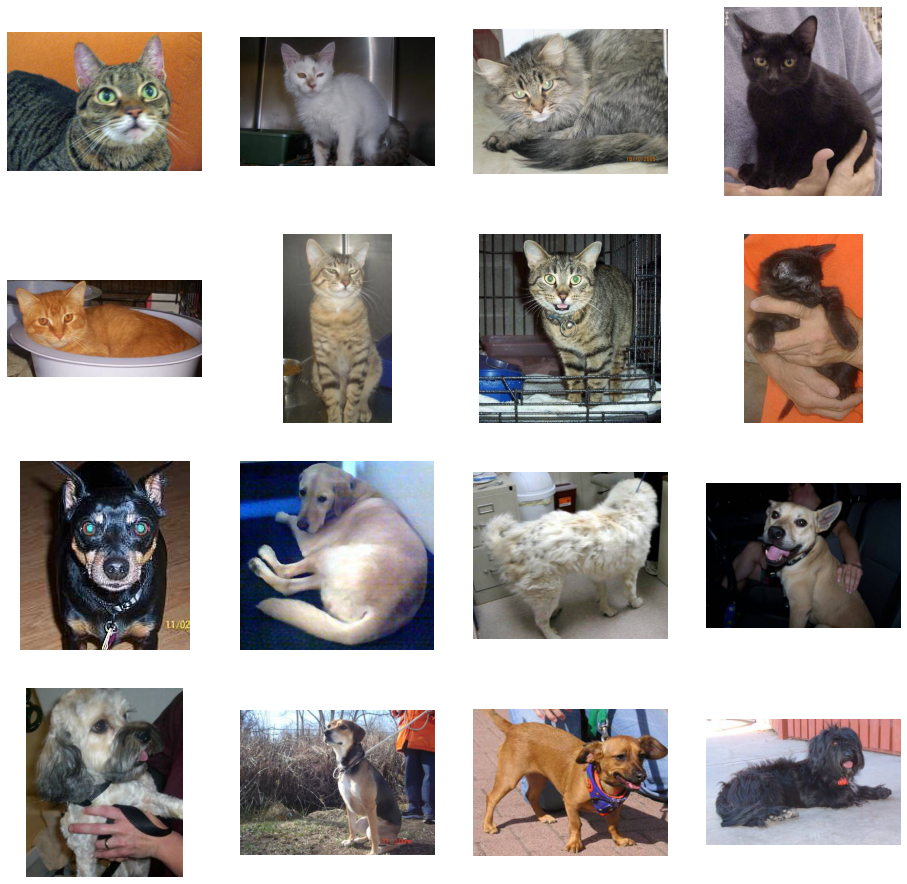

In [7]:
nrows = 4
ncols = 4

pic_idx = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_idx += 8
next_cat_pic = [os.path.join(train_cat_dir, fname) for fname in train_cat_fname[pic_idx - 8:pic_idx]]
next_dog_pic = [os.path.join(train_dog_dir, fname) for fname in train_dog_fname[pic_idx - 8:pic_idx]]

for i, img_path in enumerate(next_cat_pic + next_dog_pic):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

As you can see, each image has different shape, and some of image contains unlabeled object like human hand, cage, etc. This kind of feature makes hard to train generalization of dataset for classifying cats and dogs. See the CNN performance with naive dataset shortly.

## Tensorflow ImageDataGenerator

Anyway, of course we can make image itself for training and validation data, But tensorflow offers nice API called [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). If we can make sure the correct structure of dataset folder and appropriate options, we can define pythonic generator for dataset. To compare the performance whether the image augmentation is applied or not, let's build naive data generator. In this case, we will just apply rescale, which can make the color range between 0 and 1.

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=20,
    target_size=(150, 150),
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    batch_size=20,
    target_size=(150, 150),
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We need to think about the `target size`, `batch size`, and `class_mode`. Since we try to solve binary classification, we need to define `binary` for `class_mode`. If we want extend the problem with multiclass classification, we just set it to `categorical`. And `target_size` makes each image to default shape, and its value will affect to the `input_shape` in CNN.

After that, we can make pythonic generator that contains dataset. Thankfully, label encoding is applied automatically. If we want to find out which label is mapped, we can use `class_indices` of ImageDataGenerator.

In [10]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

## Model Build

Let's make simple CNN model. The purpose of this notebook is to show the power of image augmentation, we do not build complex model.

In [11]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [12]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history_naive = model.fit(train_generator, steps_per_epoch=100, epochs=100, validation_data=val_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 6s 54ms/step - loss: 0.7442 - accuracy: 0.5620 - val_loss: 0.6405 - val_accuracy: 0.6700
Epoch 2/100
100/100 [==============================] - 5s 52ms/step - loss: 0.6123 - accuracy: 0.6830 - val_loss: 0.6601 - val_accuracy: 0.6170
Epoch 3/100
100/100 [==============================] - 5s 52ms/step - loss: 0.5366 - accuracy: 0.7270 - val_loss: 0.5534 - val_accuracy: 0.7190
Epoch 4/100
100/100 [==============================] - 5s 53ms/step - loss: 0.4738 - accuracy: 0.7765 - val_loss: 0.5489 - val_accuracy: 0.7340
Epoch 5/100
100/100 [==============================] - 5s 54ms/step - loss: 0.4059 - accuracy: 0.8115 - val_loss: 0.5849 - val_accuracy: 0.7100
Epoch 6/100
100/100 [==============================] - 5s 54ms/step - loss: 0.3210 - accuracy: 0.8610 - val_loss: 0.5813 - val_accuracy: 0.7350
Epoch 7/100
100/100 [==============================] - 5s 52ms/step - loss: 0.2312 - accuracy: 0.9040 - val_loss: 0.6729 - val_accuracy:

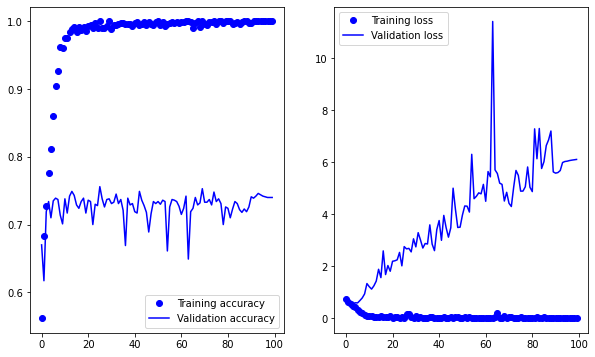

In [17]:
accuracy_naive = history_naive.history['accuracy']
val_accuracy_naive = history_naive.history['val_accuracy']
loss_naive = history_naive.history['loss']
val_loss_naive = history_naive.history['val_loss']

epochs = range(len(accuracy_naive))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy_naive, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_naive, 'b', label='Validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_naive, 'bo', label='Training loss')
plt.plot(epochs, val_loss_naive, 'b', label='Validation loss')
plt.legend()
plt.show()

As you can see, while training accuracy is almost 100%, validation accuracy stucks in 72~3%. From the result, we can make sure that overfitting is occurred, thus model is not trained well in terms of generalization.

## Image Augmentation

To overcome this problem, a few approaches exist. One definite way is gather lots of dataset, but it is hard to obtain lots of dataset in most of cases. Instead, we can generate more synthetic images from original data, such as rotation, zoom, shearing. This technique is called **Image Augmentation**. Actually, we can do this easily with previously mentioned `ImageDataGenerator`.

In [18]:
train_aug_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    rescale=1/255.
)

train_generator = train_aug_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Note that, validation dataset should be remained in original feature. So that's why we only define rescaling in validation data generator.

Let's do the same process with same model.

In [19]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [20]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history_augmentation = model.fit(train_generator, steps_per_epoch=100, epochs=100, validation_data=val_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 12s 115ms/step - loss: 0.8108 - accuracy: 0.5315 - val_loss: 0.7738 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 11s 113ms/step - loss: 0.7056 - accuracy: 0.5580 - val_loss: 0.6624 - val_accuracy: 0.5780
Epoch 3/100
100/100 [==============================] - 11s 111ms/step - loss: 0.6771 - accuracy: 0.5910 - val_loss: 0.6278 - val_accuracy: 0.6380
Epoch 4/100
100/100 [==============================] - 11s 112ms/step - loss: 0.6687 - accuracy: 0.6395 - val_loss: 0.5900 - val_accuracy: 0.6670
Epoch 5/100
100/100 [==============================] - 11s 112ms/step - loss: 0.6328 - accuracy: 0.6490 - val_loss: 0.5757 - val_accuracy: 0.6770
Epoch 6/100
100/100 [==============================] - 11s 111ms/step - loss: 0.6265 - accuracy: 0.6495 - val_loss: 0.6053 - val_accuracy: 0.6550
Epoch 7/100
100/100 [==============================] - 11s 111ms/step - loss: 0.6149 - accuracy: 0.6660 - val_loss: 0.5520 -

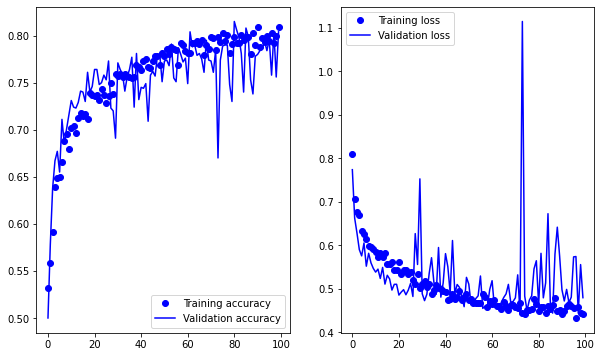

In [23]:
accuracy_aug = history_augmentation.history['accuracy']
val_accuracy_aug = history_augmentation.history['val_accuracy']
loss_aug = history_augmentation.history['loss']
val_loss_aug = history_augmentation.history['val_loss']

epochs = range(len(accuracy_aug))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy_aug, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_aug, 'b', label='Validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_aug, 'bo', label='Training loss')
plt.plot(epochs, val_loss_aug, 'b', label='Validation loss')
plt.legend()
plt.show()

As you can see, the validation accuracy is slightly increased from 72% to 80%.